In [1]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy,
    save_results,
    load_results,
)
from ema_workbench.util import ema_logging

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
import copy
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [3]:
#results_v0 = pd.read_csv("directed search results/dike_model_policy_design.csv",index_col=0)
#results_v1 = pd.read_csv("directed search results/dike_model_policy_design_big_nfe.csv",index_col=0)
results_v0 = pd.read_csv("directed search results/seed results/dike_model_policy_design_big_nfe.csv",index_col=0)

In [4]:
model, steps = get_model_for_problem_formulation(2)

### Re-evaluating Candidate Solutions under different scenarios

- Filtering policies based on hard constraints.
    - Expected Number of Deaths < 0.001
    - At least one Rfr project i.e. sum(Rfr) >=1
    - Expected Annual Damage < 0.01

In [5]:
results_v0.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths',
       'Total Investment Costs'],
      dtype='object')

In [6]:
logical_1 = results_v0['Expected Number of Deaths']<0.001
results_v0['RfR_agg']=results_v0.iloc[:,0:15].agg(['sum'],axis="columns")
logical_2 = results_v0['RfR_agg']>=1
logical_3 = results_v0['Expected Annual Damage']<0.01

In [7]:
#logical_11 = results_v1['Expected Number of Deaths']<0.001
#results_v1['RfR_agg']=results_v1.iloc[:,0:15].agg(['sum'],axis="columns")
#logical_21 = results_v1['RfR_agg']>=1
#logical_31 = results_v1['Expected Annual Damage']<0.01

In [8]:
#policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
#policies.to_csv("Filtered Policies - to be tested for robustness.csv")
policies = results_v0[logical_1 & logical_2 & logical_3]
policies.to_csv("Filtered Policies - to be tested for robustness.csv")
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs,RfR_agg
2,0,0,0,0,0,0,1,1,0,0,...,4,0,0,0.0,1.440720e+08,61400000.0,0.0,0.0,2.054720e+08,2
4,0,0,0,0,0,0,1,1,1,0,...,4,0,0,0.0,1.422034e+08,92100000.0,0.0,0.0,2.343034e+08,3
8,0,0,0,0,0,0,1,0,0,0,...,4,0,0,0.0,1.490962e+08,30700000.0,0.0,0.0,1.797962e+08,1
16,0,0,0,0,0,0,1,0,0,0,...,3,0,0,0.0,1.410464e+08,151900000.0,0.0,0.0,2.929464e+08,2


In [9]:
#policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns=['RfR_agg'])
policies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 2 to 16
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   0_RfR 0             4 non-null      int64
 1   0_RfR 1             4 non-null      int64
 2   0_RfR 2             4 non-null      int64
 3   1_RfR 0             4 non-null      int64
 4   1_RfR 1             4 non-null      int64
 5   1_RfR 2             4 non-null      int64
 6   2_RfR 0             4 non-null      int64
 7   2_RfR 1             4 non-null      int64
 8   2_RfR 2             4 non-null      int64
 9   3_RfR 0             4 non-null      int64
 10  3_RfR 1             4 non-null      int64
 11  3_RfR 2             4 non-null      int64
 12  4_RfR 0             4 non-null      int64
 13  4_RfR 1             4 non-null      int64
 14  4_RfR 2             4 non-null      int64
 15  EWS_DaysToThreat    4 non-null      int64
 16  A.1_DikeIncrease 0  4 non-null      int64
 17  A.1_D

In [13]:
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [14]:
len(policies_to_evaluate)

4

In [ ]:
n_scenarios=100

In [15]:
print(f"Evaluating {len(policies_to_evaluate)} policies across {n_scenarios} scenarios")

NameError: name 'n_scenarios' is not defined

In [16]:
import random
random.seed(123)

In [42]:
#with MultiprocessingEvaluator(model) as evaluator:
with SequentialEvaluator(model) as evaluator:
    scenario_results = evaluator.perform_experiments(n_scenarios,policies_to_evaluate)

100%|██████████████████████████████████████████| 60/60 [03:37<00:00,  3.63s/it]


In [48]:
save_results(scenario_results, "directed search results/policy_robustness_1000_scenarios.tar.gz")

### Calculating Signal to Noise Ratio

In [10]:
scenario_results=load_results("directed search results/policy_robustness_2000_scenarios.tar.gz")

In [11]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [12]:
experiments, outcomes = scenario_results
np.unique(experiments['policy'])

array([ 2,  4,  8, 16], dtype=int64)

In [13]:
experiments, outcomes = scenario_results
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
2,5.583236e+17,4.293679,0.0,2.207849e+08,0.004868,3.561748e+12
4,5.431893e+17,8.475985,0.0,2.023476e+08,0.004659,3.932578e+12
8,6.140228e+17,8.886829,0.0,3.106792e+08,0.006545,3.747640e+12
16,5.919362e+17,4.203509,0.0,2.710109e+08,0.005746,5.672196e+12


In [14]:
ooi=scores.columns.tolist()
ooi

['Expected Annual Damage',
 'Dike Investment Costs',
 'RfR Investment Costs',
 'Evacuation Costs',
 'Expected Number of Deaths',
 'Total Investment Costs']

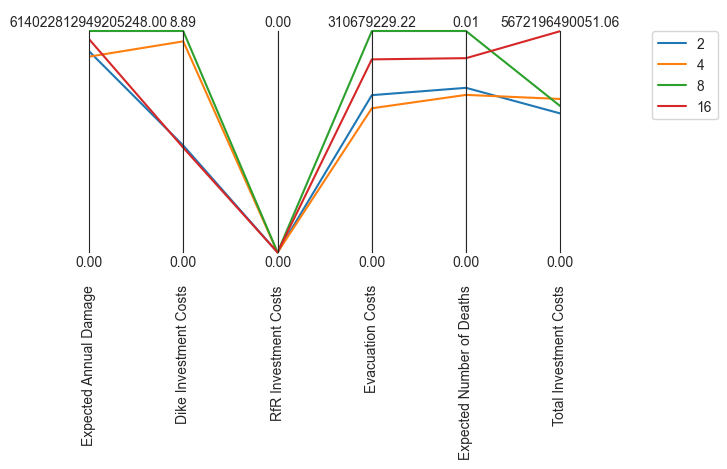

In [16]:
from ema_workbench.analysis import parcoords


colors = sns.color_palette()
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig("directed search results/parcoord for SNR plot.png",bbox_inches='tight')
plt.show()


## Calculating regret

In [128]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [129]:
experiments, outcomes = scenario_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.min(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

In [130]:
data

policy,2,4,8,16
scenario,,,,
0,2.055053e+08,2.343350e+08,1.798266e+08,2.929786e+08
1,2.054924e+08,2.343244e+08,1.798145e+08,2.929646e+08
2,2.054720e+08,2.343035e+08,1.797972e+08,2.929473e+08
3,2.054821e+08,2.343139e+08,1.798058e+08,2.929540e+08
4,2.054725e+08,2.343037e+08,1.797966e+08,2.929468e+08
...,...,...,...,...
1995,2.055213e+08,2.343407e+08,1.798901e+08,2.930294e+08
1996,2.054743e+08,2.343058e+08,1.798002e+08,2.929503e+08
1997,2.054740e+08,2.343057e+08,1.797995e+08,2.929495e+08


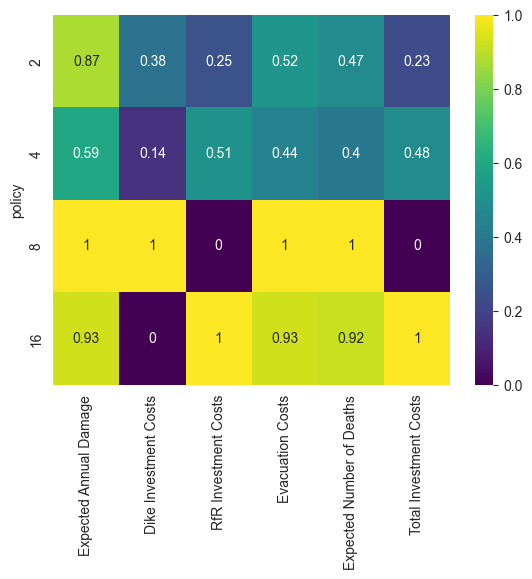

In [133]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("directed search results/heatmap for max regret plot.png", bbox_inches='tight')
plt.show()

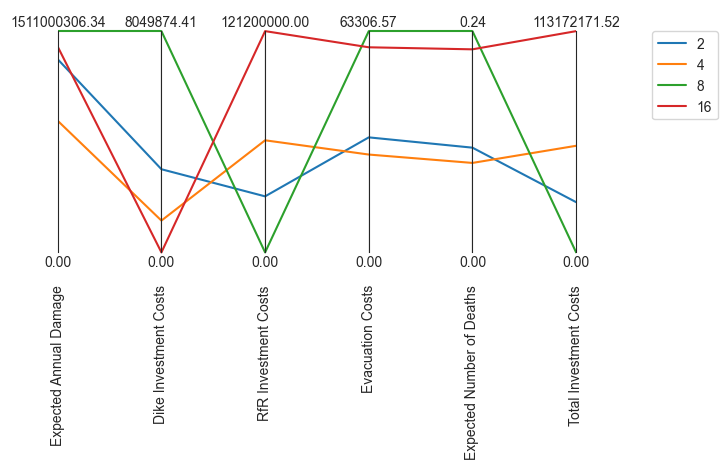

In [134]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits,fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig("directed search results/parcoord for regret plot.png",bbox_inches='tight')
plt.show()

In [135]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

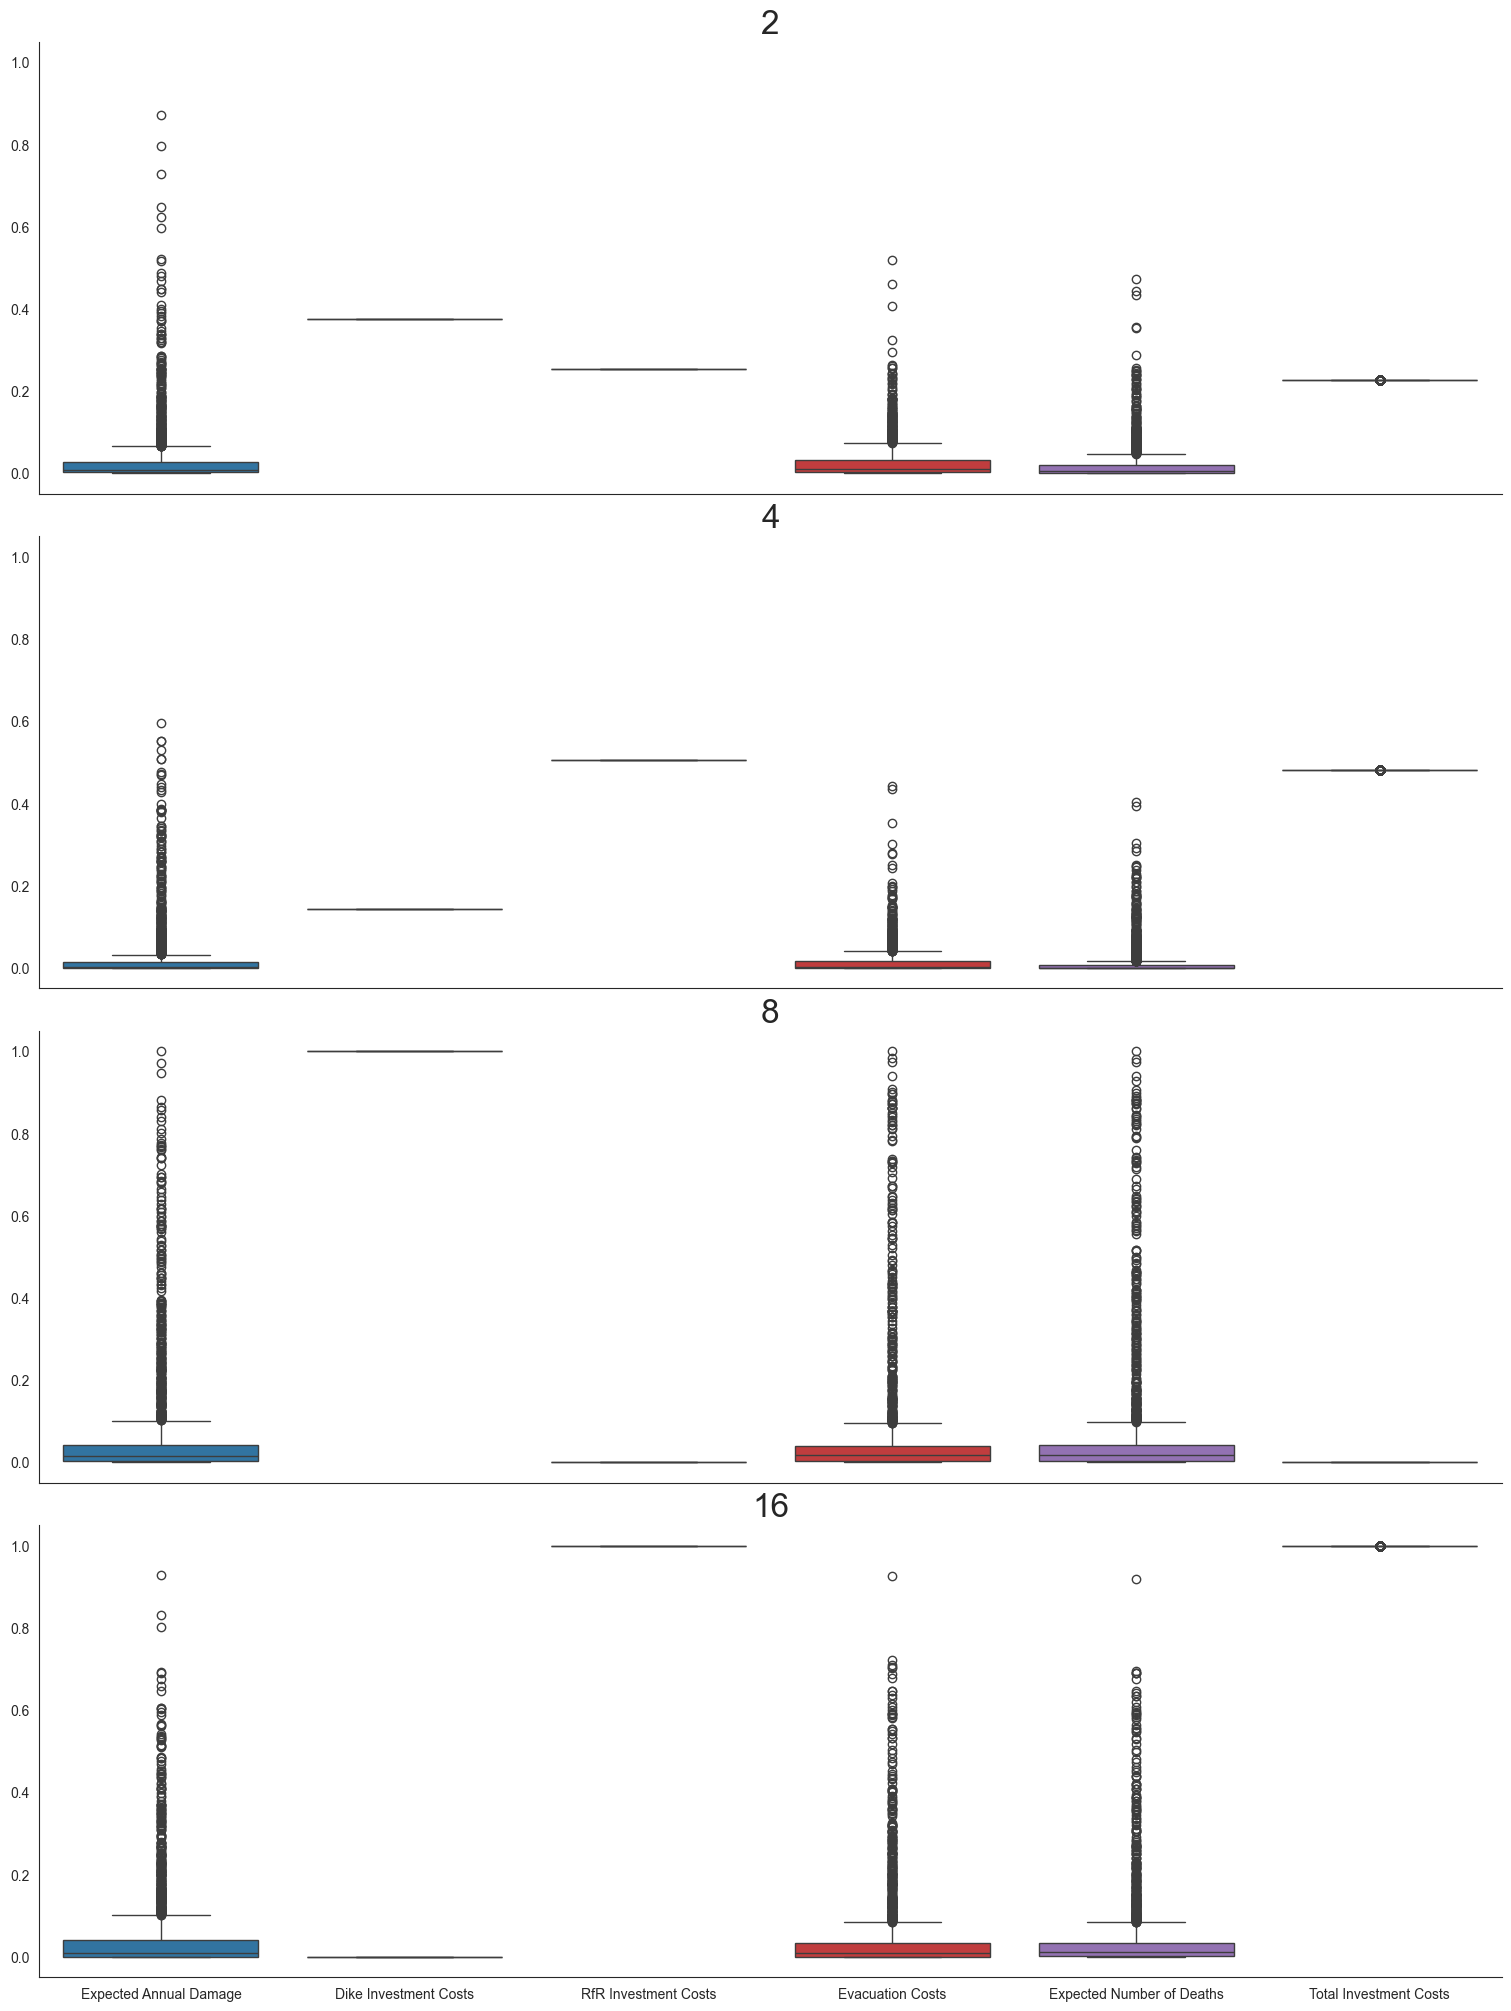

In [136]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots( nrows=4, figsize=(15,20), 
                         sharey=True, sharex=True,constrained_layout=True)
#axes.flatten()

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy),fontsize=24)


plt.savefig("directed search results/boxplot for regret.png")
plt.show()

## Scenario Discovery
Under which conditions do these policies result in poor performance?

In [68]:
experiments, outcomes = scenario_results

In [69]:
from ema_workbench.analysis import prim

x = experiments.drop(labels=[l.name for l in model.levers], axis=1)
#x=x.drop(labels=['scenario','model','policy'],axis=1)
#y = outcomes['Expected Annual Damage'] > 0.1
y = (outcomes['Expected Number of Deaths']) > 0 & (outcomes['Expected Annual Damage'] > 0.1)


In [70]:
x.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', 'num_events', 'scenario', 'policy', 'model'],
      dtype='object')

In [71]:
prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box = prim_alg.find_box()

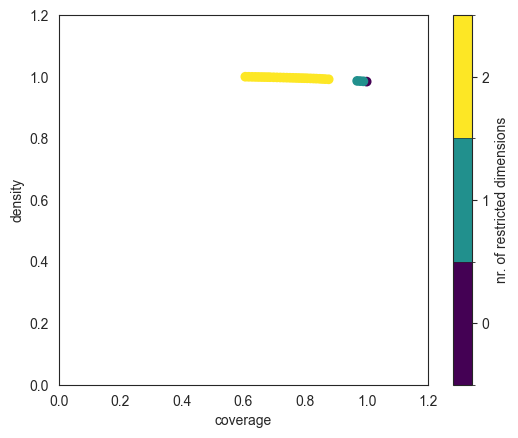

In [114]:
import matplotlib.pyplot as plt
box.show_tradeoff(annotated=False)
plt.savefig('prim_policies/PRIM_coverage_density_tradeoff_not_annotated.png',bbox_inches='tight')
plt.show()


In [115]:
point = 4
box.inspect(point)

coverage       0.876667
density        0.991667
id             4.000000
k           6902.000000
mass           0.870000
mean           0.991667
n           6960.000000
res_dim        2.000000
Name: 4, dtype: float64

                                                        box 4  \
                                                          min   
A.2_pfail                                            0.000104   
num_events  {30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...   

                                                                         \
                                                          max  qp value   
A.2_pfail                                            0.899423       NaN   
num_events  {30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...  0.021594   

                      
            qp value  
A.2_pfail   0.000033  
num_events       NaN  



C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4

[None]

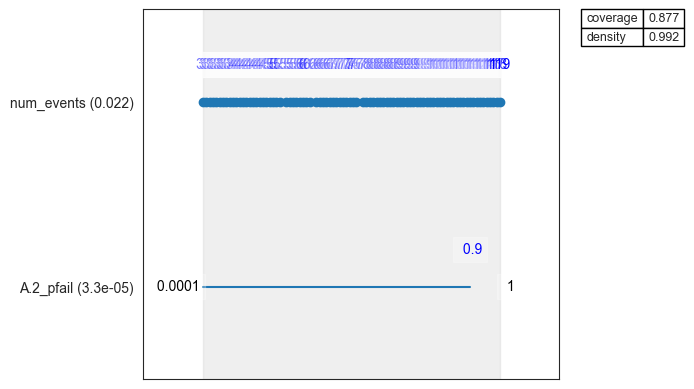

In [121]:
point = 4
box.inspect(point,style='graph')
plt.savefig('prim_inspection_4.png',bbox_inches='tight')

In [120]:
resample_b4=box.resample(point)
resample_b4.to_csv("prim_policies/resampling_box_point4.csv")

In [74]:
df_box0=prim_alg.stats_to_dataframe()
df_box_for_box0=prim_alg.boxes_to_dataframe()

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:929: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_boxes.loc[unc][index[i]] = values.values


In [99]:
df_box0.to_csv('prim_policies/PRIM_box0.csv')

In [100]:
df_box_for_box0.to_csv('prim_policies/PRIM_box0_stats.csv')

In [104]:
box.inspect_tradeoff()
#plt.savefig('prim_policies/trade_off_plots.png')

alt.VConcatChart(...)

[<Figure size 640x480 with 1 Axes>]

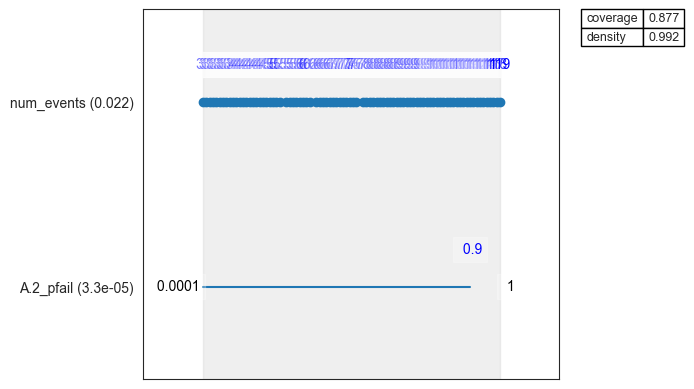

In [106]:
box.inspect(4,style='graph')

[<Figure size 640x480 with 1 Axes>]

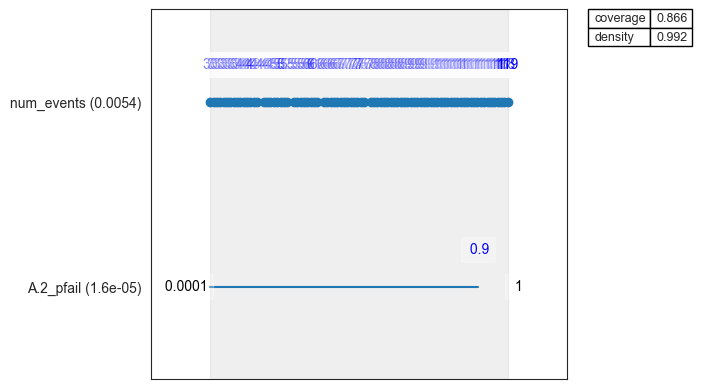

In [111]:
box.inspect(5,style='graph')

In [89]:
box1 = prim_alg.find_box()

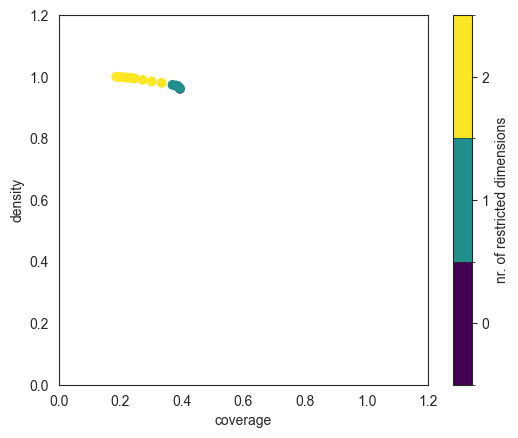

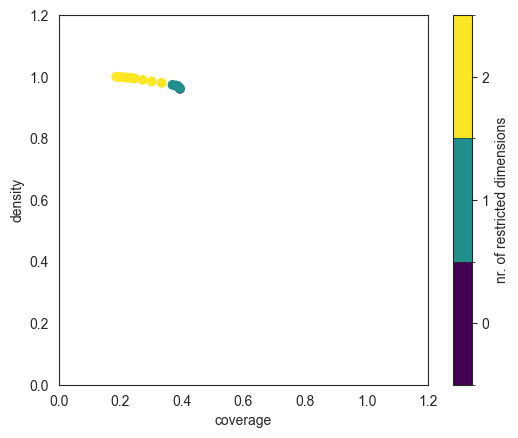

In [90]:
box1.show_tradeoff()

In [91]:
prim_df=prim_alg.stats_to_dataframe()
prim_box_df=prim_alg.boxes_to_dataframe()

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:929: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_boxes.loc[unc][index[i]] = values.values


In [92]:
prim_df

,coverage,density,mass,res_dim
box 1,0.606122,1.0,0.5965,2
box 2,0.186968,1.0,0.1840,2


In [93]:
prim_box_df

box 1  \
                                                          min   
num_events  {30, 31, 32, 36, 37, 39, 40, 41, 42, 44, 46, 4...   
A.2_pfail                                            0.000104   
A.4_pfail                                            0.000116   

                                                               \
                                                          max   
num_events  {30, 31, 32, 36, 37, 39, 40, 41, 42, 44, 46, 4...   
A.2_pfail                                            0.899423   
A.4_pfail                                            0.999734   

                                                        box 2  \
                                                          min   
num_events  {30, 32, 34, 36, 38, 39, 42, 43, 44, 45, 46, 4...   
A.2_pfail                                            0.000104   
A.4_pfail                                            0.000116   

                                                               
                                                          max  
num_events  {30, 32, 34, 36, 38, 39, 42, 43, 44, 45, 46, 4...  
A.2_pfail                                            0.999858  
A.4_pfail                                            0.639776

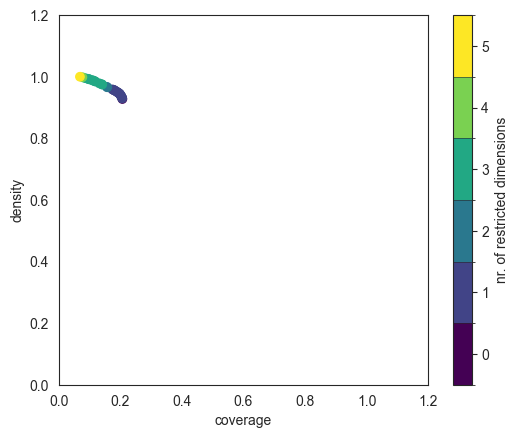

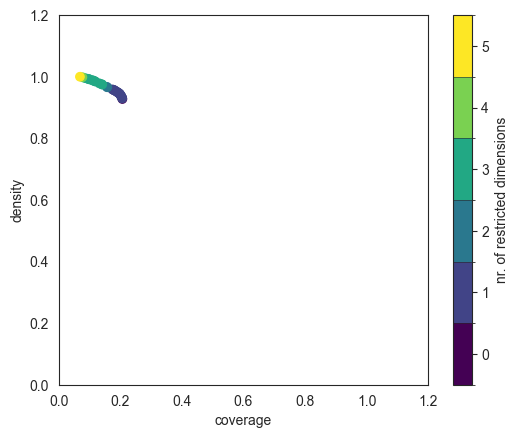

In [94]:
box2 = prim_alg.find_box()
box2.show_tradeoff()

In [95]:
prim_df_box2=prim_alg.stats_to_dataframe()
prim_box_df_box2=prim_alg.boxes_to_dataframe()

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:929: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_boxes.loc[unc][index[i]] = values.values


In [96]:
prim_df_box2

,coverage,density,mass,res_dim
box 1,0.606122,1.0,0.5965,2
box 2,0.186968,1.0,0.1840,2
box 3,0.069097,1.0,0.0680,5


In [97]:
prim_box_df_box2

box 1  \
                                                          min   
num_events  {30, 31, 32, 36, 37, 39, 40, 41, 42, 44, 46, 4...   
A.2_pfail                                            0.000104   
A.1_Bmax                                            30.144967   
A.4_pfail                                            0.000116   
A.5_Bmax                                            30.118203   
A.2_Bmax                                            30.080374   
A.4_Bmax                                            30.019985   

                                                               \
                                                          max   
num_events  {30, 31, 32, 36, 37, 39, 40, 41, 42, 44, 46, 4...   
A.2_pfail                                            0.899423   
A.1_Bmax                                           349.881345   
A.4_pfail                                            0.999734   
A.5_Bmax                                           349.996875   
A.2_Bmax                                           349.988706   
A.4_Bmax                                           349.905536   

                                                        box 2  \
                                                          min   
num_events  {30, 32, 34, 36, 38, 39, 42, 43, 44, 45, 46, 4...   
A.2_pfail                                            0.000104   
A.1_Bmax                                            30.144967   
A.4_pfail                                            0.000116   
A.5_Bmax                                            30.118203   
A.2_Bmax                                            30.080374   
A.4_Bmax                                            30.019985   

                                                               \
                                                          max   
num_events  {30, 32, 34, 36, 38, 39, 42, 43, 44, 45, 46, 4...   
A.2_pfail                                            0.999858   
A.1_Bmax                                           349.881345   
A.4_pfail                                            0.639776   
A.5_Bmax                                           349.996875   
A.2_Bmax                                           349.988706   
A.4_Bmax                                           349.905536   

                                                        box 3  \
                                                          min   
num_events  {30, 32, 33, 35, 36, 39, 42, 44, 46, 48, 50, 5...   
A.2_pfail                                            0.000104   
A.1_Bmax                                            62.008466   
A.4_pfail                                            0.000116   
A.5_Bmax                                            30.118203   
A.2_Bmax                                            30.080374   
A.4_Bmax                                            30.019985   

                                                               
                                                          max  
num_events  {30, 32, 33, 35, 36, 39, 42, 44, 46, 48, 50, 5...  
A.2_pfail                                            0.999858  
A.1_Bmax                                           349.881345  
A.4_pfail                                            0.999734  
A.5_Bmax                                           318.540852  
A.2_Bmax                                           319.325246  
A.4_Bmax                                           282.441157